In [15]:
import numpy as np
import corner
import matplotlib.pyplot as plt
%matplotlib inline
import scipy
from numpy import sqrt, sin, cos, pi, exp
from astropy.cosmology import FlatLambdaCDM
cosmo = FlatLambdaCDM(H0=70, Om0=0.3, Tcmb0=2.725)
from matplotlib import font_manager as fm, rcParams
import os

import emcee


In [2]:
def model1(params, t):
    m, b, amp, loc1, sig1, loc2, sig2 = params
    return m*t + b + amp * (np.exp(-0.5 * (t - loc1) ** 2 / sig1**2) + np.exp(-0.5 * (t + loc2) ** 2 / sig2**2))

def lnlike1(p, t, y, yerr):
    return -0.5 * np.sum(((y - model1(p, t))/yerr) ** 2)

def lnprior1(p):
    m, b, amp, loc1, sig1, loc2, sig2 = p
    if (-10 < m < 10 and  -10 < b < 10 and -10 < amp < 10 and -5 < loc1 < 5 and 0 < sig1 < 3 and -5 < loc2 < 5 and 0 < sig2 < 3):
        return 0.0
    return -np.inf

def lnprob1(p, x, y, yerr):
    lp = lnprior1(p)
    return lp + lnlike1(p, x, y, yerr) if np.isfinite(lp) else -np.inf


In [3]:
def Tdust_plank(p, x):
    Tdust, flux = p
    beta = 1.8
    c = 3.e10
    h = 6.626e-27
    kb= 1.38e-16
    nu = c/x/1.e-4
    kappa0 = 0.4
    nu0 = c/1200.e-4
    
    return 1.e23 * flux *kappa0 * (nu/nu0)**beta * 2 * h * nu**(3.)/(np.exp(h*nu/kb/Tdust)-1.) / c**2. * 2.e33 / (3.086e+24)**2.

In [4]:
beta = 1.8

c = 3.e10
h = 6.626e-27
kb= 1.38e-16
kappa0 = 0.4
nu0 = c/1200.e-4


wavelength_rest = np.arange(10, 10+1300)
nu_rest = c/(wavelength_rest*1.e-4)

wavelength_rest_FIR = np.arange(8,8+993)

#8-1000:
nu_rest_FIR = (np.arange(3, 3+373))*1.e11
#3-1100
nu_rest_TIR = (2.7272727 + np.arange(0,1001) * (1000.0000 - 2.7272727) / 1000.)*1.e11

In [5]:
x = np.arange(3, 3+373)
x.shape

(373,)

In [8]:
a=np.loadtxt('id141_sed_dust.txt',skiprows=1)

In [9]:
a

array([[2.5000000e+02, 1.1500000e+02, 1.9000000e+01],
       [3.5000000e+02, 1.9200000e+02, 3.0000000e+01],
       [5.0000000e+02, 2.0400000e+02, 3.2000000e+01],
       [8.7000000e+02, 1.0200000e+02, 8.8000000e+00],
       [8.8000000e+02, 9.0000000e+01, 5.0000000e+00],
       [1.0354539e+03, 5.2000000e+01, 5.2200000e+00],
       [1.2000000e+03, 3.6000000e+01, 2.0000000e+00],
       [1.9500000e+03, 9.7000000e+00, 9.0000000e-01],
       [2.7500000e+03, 1.8000000e+00, 3.0000000e-01],
       [3.0000000e+03, 1.6000000e+00, 2.0000000e-01],
       [3.2900000e+03, 1.2000000e+00, 1.0000000e-01]])

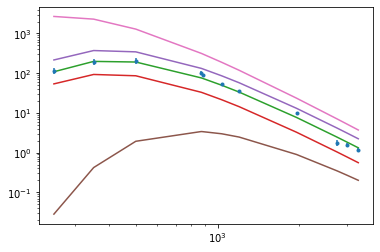

In [13]:
plt.errorbar(a[:,0],a[:,1],a[:,2],fmt='.')

p0=[39.,24504.]

plt.loglog(np.nan)

plt.plot(a[:,0], Tdust_plank(p0,a[:,0]/5.24))
plt.plot(a[:,0], Tdust_plank([40,10000],a[:,0]/5.24))
plt.plot(a[:,0], Tdust_plank([40,40000],a[:,0]/5.24))

plt.plot(a[:,0], Tdust_plank([20,10000],a[:,0]/5.24))
plt.plot(a[:,0], Tdust_plank([60,40000],a[:,0]/5.24))

data = (a[:,0]/(1+4.24), a[:,1], a[:,2])


In [14]:

def lnlike1(p, t, y, yerr):
    return -0.5 * np.sum(((y - Tdust_plank(p, t))/yerr) ** 2)

def lnprior1(p):
    Tdust, flux = p
    if (30. < Tdust < 100. and  10000. < flux < 90000.):
        return 0.0
    return -np.inf

def lnprob1(p, x, y, yerr):
    lp = lnprior1(p)
    return lp + lnlike1(p, x, y, yerr) if np.isfinite(lp) else -np.inf

In [16]:

nwalkers=32

initial = np.array(p0)
ndim = len(initial)
p0 = np.array(initial) + 1.5 * np.random.randn(nwalkers, ndim)
sampler = emcee.EnsembleSampler(nwalkers, ndim, lnprob1, args=data)

print("Running burn-in...")
p0, _, _ = sampler.run_mcmc(p0, 1000, progress=True)
sampler.reset()

print("Running production...")
sampler.run_mcmc(p0, 5000, progress=True)


Running burn-in...


100%|██████████| 1000/1000 [00:01<00:00, 715.90it/s]


Running production...


100%|██████████| 5000/5000 [00:06<00:00, 789.58it/s]


State([[   38.77849342 25709.01612979]
 [   39.15767375 25317.82299183]
 [   39.23129302 26667.22201292]
 [   40.39025487 23772.50567159]
 [   39.50423079 25240.11933429]
 [   39.71365668 23722.36412282]
 [   40.04599198 24974.62659107]
 [   39.65621381 26646.6174213 ]
 [   39.16592499 26041.08102677]
 [   38.23910602 25223.29478344]
 [   41.26714193 23001.73365042]
 [   41.17867738 21819.08056341]
 [   39.80878133 25121.41299482]
 [   40.07420041 24816.88943762]
 [   38.45687997 26374.58451707]
 [   40.71982882 23515.6389209 ]
 [   39.81939559 25445.37213999]
 [   40.48156593 24667.63080231]
 [   39.87353752 25978.60751665]
 [   39.59861207 22550.38402601]
 [   39.61038061 25705.76808741]
 [   40.01318499 25506.77656987]
 [   40.60758136 23530.82568751]
 [   38.86702891 26329.41526049]
 [   40.5546984  23429.91040583]
 [   40.81908498 23648.26387209]
 [   38.95638112 26124.1386608 ]
 [   39.45731102 24907.93769351]
 [   39.64080631 25362.04737407]
 [   39.13675516 26098.08812947]
 [  

(10240, 2)


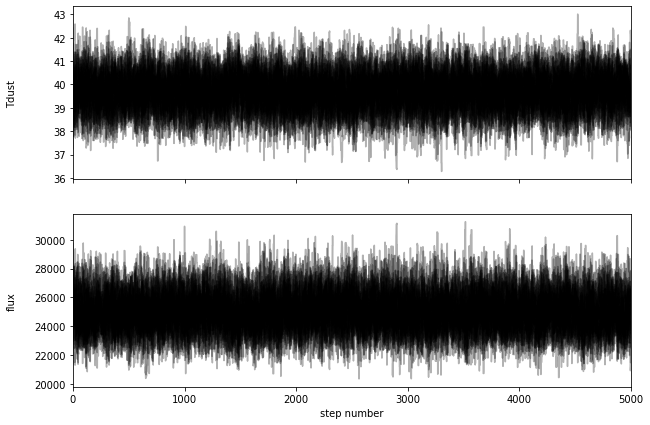

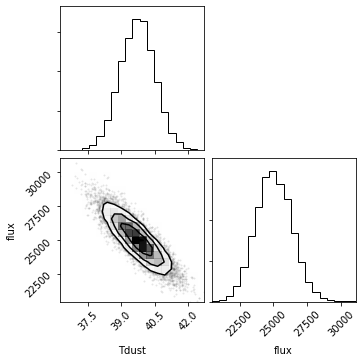

In [17]:
fig, axes = plt.subplots(2, figsize=(10, 7), sharex=True)
samples = sampler.get_chain()
labels = ["Tdust", "flux"]
for i in range(ndim):
    ax = axes[i]
    ax.plot(samples[:, :, i], "k", alpha=0.3)
    ax.set_xlim(0, len(samples))
    ax.set_ylabel(labels[i])
    ax.yaxis.set_label_coords(-0.1, 0.5)

axes[-1].set_xlabel("step number");

import corner
flat_samples = sampler.get_chain(discard=200, thin=15, flat=True)
print(flat_samples.shape)
fig = corner.corner(flat_samples, labels=labels);

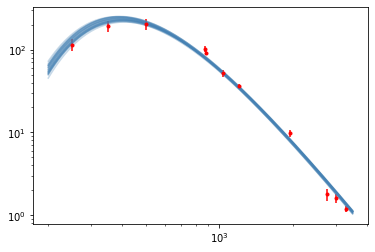

In [18]:
plt.loglog(np.nan)
plt.errorbar(a[:,0],a[:,1],a[:,2],fmt='.r')
x1 = np.linspace(200, 3500, 500)
for s in sampler.flatchain[np.random.randint(len(sampler.flatchain), size=24)]:
    plt.plot(x1, Tdust_plank(s, x1/(1+4.24)), color="#4682b4", alpha=0.3)
#plt.title("results assuming uncorrelated noise")

In [20]:
samples.shape

(5000, 32, 2)

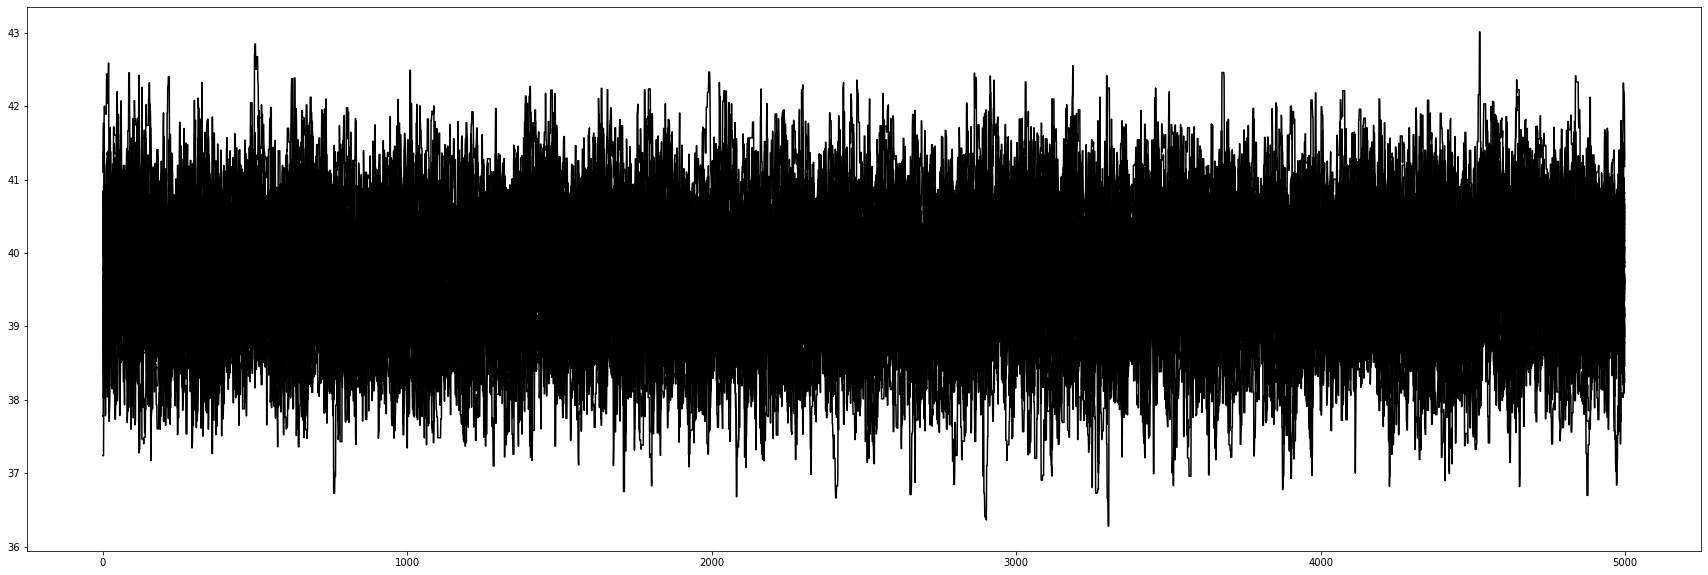

In [28]:
plt.figure(1, figsize=(30,10))
plt.plot(samples[:, :, 0], "k")


(array([   80.,   822.,  5066., 21655., 45844., 51536., 27106.,  6826.,
         1004.,    61.]),
 array([36.27857194, 36.95189374, 37.62521555, 38.29853736, 38.97185916,
        39.64518097, 40.31850277, 40.99182458, 41.66514639, 42.33846819,
        43.01179   ]),
 <BarContainer object of 10 artists>)

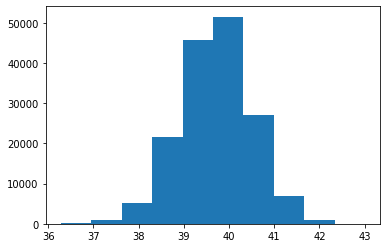

In [30]:
plt.hist(samples[:, :, 0].flatten())

(array([   80.,   822.,  5066., 21655., 45844., 51536., 27106.,  6826.,
         1004.,    61.]),
 array([36.27857194, 36.95189374, 37.62521555, 38.29853736, 38.97185916,
        39.64518097, 40.31850277, 40.99182458, 41.66514639, 42.33846819,
        43.01179   ]),
 <BarContainer object of 10 artists>)

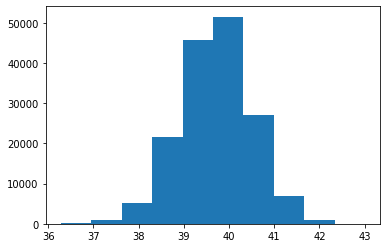

In [31]:
from astropy.visualization import hist

hist(samples[:,:,0].flatten())


AttributeError: module 'matplotlib.mlab' has no attribute 'normpdf'

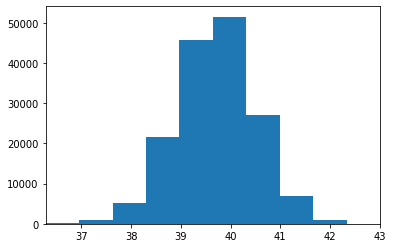

In [33]:
import astropy.stats.histogram
import matplotlib.mlab as mlab

#hist(samples[:,:,0].flatten())

arr = samples[:,:,0].flatten()

plt.figure(1)
result = plt.hist(arr)
plt.xlim((min(arr), max(arr)))

mean = np.mean(arr)
variance = np.var(arr)
sigma = np.sqrt(variance)
x = np.linspace(min(arr), max(arr), 100)
dx = result[1][1] - result[1][0]
scale = len(arr)*dx
plt.plot(x, mlab.normpdf(x, mean, sigma)*scale)

T_dust = np.median(arr)
variance


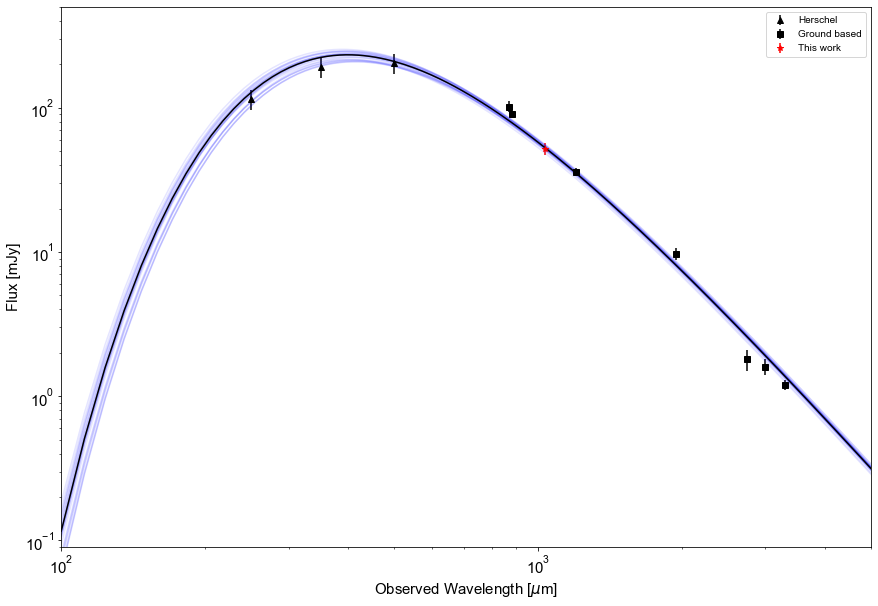

In [44]:
import matplotlib
matplotlib.rcParams['font.family'] = 'Arial'


plt.figure(1, figsize = (15,10))

plt.loglog(np.nan)
plt.errorbar(a[0:3,0],a[0:3,1],a[0:3,2],fmt='.k', marker="^",label='Herschel')
plt.errorbar(a[3:5,0],a[3:5,1],a[3:5,2],fmt='.k', marker="s",label='Ground based')
plt.errorbar(a[5,0],a[5,1],a[5,2],fmt='.r', marker="*",label='This work')
plt.errorbar(a[6:11,0],a[6:11,1],a[6:11,2],fmt='.k', marker="s")

#plt.errorbar(a[:,0],a[:,1],a[:,2],fmt='.r', marker="*")
#plt.errorbar(a[:,0],a[:,1],a[:,2],fmt='.r', marker="*")
#plt.errorbar(a[:,0],a[:,1],a[:,2],fmt='.r', marker="*")
#plt.errorbar(a[:,0],a[:,1],a[:,2],fmt='.r', marker="*")



x1 = np.linspace(100, 6000, 500)
for s in sampler.flatchain[np.random.randint(len(sampler.flatchain), size=24)]:
    plt.plot(x1, Tdust_plank(s, x1/(1+4.24)), color="b", alpha=0.1)
#plt.title("results assuming uncorrelated noise")

pp = [np.median(samples[:,:,0].flatten()), np.median(samples[:,:,1].flatten())]
plt.plot(x1, Tdust_plank(pp, x1/(1+4.24)), color = 'k')

#
#fpath = os.path.join(rcParams["datapath"], "fonts/ttf/HersheyComplexItalic.ttf")
#ComplexItalic = fm.FontProperties(fname=fpath)
#
#fpath = os.path.join(rcParams["datapath"], "fonts/ttf/HersheyComplexGreek.ttf")
#ComplexGreek = fm.FontProperties(fname=fpath)
#
#fpath = os.path.join(rcParams["datapath"], "fonts/ttf/HersheyComplexRoman.ttf")
#ComplexRoman = fm.FontProperties(fname=fpath)

#plt.yticks(family='AVHershey Complex', size = 15)
#plt.xticks(family='AVHershey Complex', size = 15)
#plt.rcParams['axes.unicode_minus']=False

#plt.yticks(fontproperties = ComplexRoman, size = 15)
#plt.xticks(fontproperties = ComplexRoman, size = 15)

#plt.title('This is some random font L, 1,2 ,3', family='Hershey Complex Italic', size=32)

#plt.xlabel(r"Observed Wavelength [$\mu$m]", fontproperties = ComplexRoman, size = 15)
#plt.ylabel("Flux [mJy]", fontproperties = ComplexRoman, size = 15)
#
#plt.text(200, 3, r"Log($M_{\rm dust}/M_\odot$) = 9.9", fontproperties = ComplexRoman, size = 14)
#plt.text(200, 1, r"Log($L_{\rm FIR}/L_\odot$) = 14.0", fontproperties = ComplexRoman, size = 14)
#
#plt.text(200, 0.35, r"$T_{\rm dust}$= 39.8 K with $\beta$=1.8 fixed", fontproperties = ComplexRoman, size = 14)




plt.yticks(size = 15)
plt.xticks(size = 15)

plt.xlabel(r"Observed Wavelength [$\mu$m]", size = 15)
plt.ylabel("Flux [mJy]", size = 15)

#plt.text(200, 3, r"Log($M_{\rm dust}/M_\odot$) = 9.9", size = 15)
#plt.text(200, 1, r"Log($L_{\rm FIR}/L_\odot$) = 14.0", size = 15)
#plt.text(200, 0.35, r"$T_{\rm dust}$= 39.8 K with $\beta$=1.8 fixed", size = 15)


plt.xlim(100,5000)
plt.ylim(0.09,500)

plt.legend(loc='upper right') # bbox_to_anchor=(0.5, 0.5))

plt.subplots_adjust(left=0.15, bottom=0.15, right=0.9, top=0.9, wspace=0.1, hspace=0.1)


plt.savefig('ID141-SED.png', dpi=300)
#ax.set_ylabel("Median Population", fontname="Arial", fontsize=12)